#Part A — Notebook Setup



In [ ]:
%%capture
!pip install transformers>=4.41.2 accelerate>=0.31.0

# Part B — Looking Inside a Language Model

## 1. Load a causal LLM and tokenizer
#### Loading the LLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=50,
    do_sample=False,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing `generation_config` together with generation-related arguments=({'do_sample', 'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


## 2. Generate text for a business-related prompt
#### The Inputs and Outputs of a Trained Transformer LLM

In [ ]:
prompt = "Develop a concise business plan for a healthcare technology company like Epic to increase profitability, increase value, and decrease cost and expenditures while minimizing layoffs."

output = generator(prompt)

print(output[0]['generated_text'])

Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)




### Answer:

**Executive Summary:**

Epic Healthcare Solutions is a healthcare technology company that specializes in developing and implementing innovative software solutions to improve patient care, streamline operations, and


## 3. Inspect model architecture (high-level)

In [ ]:
print(model)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_featur

## 4. Demonstrate next-token selection from logits
#### Choosing a single token from the probability distribution (sampling / decoding)

In [ ]:
prompt = "We choose to go to the moon in this decade and do the other things, not because they are easy, but because they are"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Tokenize the input prompt
input_ids = input_ids.to("cuda")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)

# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [ ]:
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

'hard'

In [ ]:
model_output[0].shape

torch.Size([1, 27, 3072])

In [ ]:
lm_head_output.shape

torch.Size([1, 27, 32064])

## 5. Compare generation speed with and without caching
#### Speeding up generation by caching keys and values

In [ ]:
prompt = "Develop a concise business plan for a healthcare technology company like Epic to increase profitability, increase value, and decrease cost and expenditures while minimizing layoffs."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

In [ ]:
# Generation speed with caching

%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=True
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


6.46 s ± 2.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Generation speed without caching

%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=False
)

35.5 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Part C — Text Classification

## Data Loading & Inspection

In [ ]:
# Imports

%%capture
!pip install transformers sentence-transformers openai
!pip install -U datasets

from datasets import load_dataset

In [ ]:
# Load yelp_polarity

dataset_A = load_dataset("yelp_polarity")

# Inspect splits and sample records
dataset_A


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [ ]:
# Inspect text and label fields
dataset_A["train"][0, -1]

{'text': ["Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",
  "Ryan Rocks! I called him this morning for some sprinkler help and some potential landscaping for my backyard. He showed up to my house within an hour and answered all of my questions! When I showed him how my irrigation box was leaking, he knew right away what to do - he went a grabbed a new part out of his truck, put it on, and it was fi

In [ ]:
# Prepare text and label fields

# train split
dataset_A_train_texts = dataset_A["train"]["text"] # X_Train
dataset_A_train_labels = dataset_A["train"]["label"] # y_train

# test split
dataset_A_test_texts = dataset_A["test"]["text"] # X_test
dataset_A_test_labels = dataset_A["test"]["label"] # y_test

# Define label names
dataset_A_label_names = ["Negative", "Positive"]


In [ ]:
print(type(dataset_A_train_texts))
print(dataset_A_train_texts)
print()

<class 'datasets.arrow_dataset.Column'>
Column(["Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.", "Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you

# Classification Approaches

In [ ]:
# Model depdendencies imports
from transformers import pipeline
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Helper functions in evaluating model performance
# C: Modified from Chapter 4 to appear more robust

import numpy as np # Ensure numpy is imported for np.unique and np.concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(y_true, y_pred, target_names=None):
    # Identify all unique labels that are actually present in y_true and y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # If target_names are provided, map them to the unique labels
    # Otherwise, classification_report will use the unique labels directly
    if target_names is not None:
        # Create a dictionary to map numerical labels to their names
        # Assuming label IDs are contiguous from 0 to len(target_names)-1
        label_map = {i: name for i, name in enumerate(target_names)}
        filtered_target_names = [label_map[label_id] for label_id in unique_labels if label_id in label_map]
    else:
        filtered_target_names = None

    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_target_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels) # Pass labels to confusion_matrix as well
    plt.figure(figsize=(10, 8)) # Increase figure size for better readability of many labels
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=filtered_target_names, yticklabels=filtered_target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Classification Approaches for Dataset A

### **Using a Task-sepcific model**

#### Approach 1: Task-Specific Classification Model

In [ ]:
from transformers import pipeline

# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load model into pipeline
pipe = pipeline(
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True,
    truncation=True, # Add truncation
    max_length=512, # Set max length
    device="cuda:0"
)

'''
Truncation and max length assigned to help with speed
'''

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Run inference
y_pred = []
for output_raw in tqdm(pipe(KeyDataset(dataset_A["test"], "text")), total=len(dataset_A["test"])):
    # The pipeline is observed to return a single dictionary for the top prediction,
    # e.g., {'label': 'LABEL_2', 'score': 0.95},
    # rather than a list of dictionaries for all scores despite return_all_scores=True.
    # Therefore, we directly use the predicted label.

    predicted_label = output_raw['label']

    # Map the predicted label to 0 (negative) or 1 (positive)
    if predicted_label == "LABEL_0": # Negative
        y_pred.append(0)
    elif predicted_label == "LABEL_2": # Positive
        y_pred.append(1)
    else: # Handle LABEL_1 (neutral). For this binary classification, we'll map neutral to 0 (negative).
        y_pred.append(0)


100%|██████████| 38000/38000 [10:10<00:00, 62.20it/s]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     19000
    Positive       0.00      0.00      0.00     19000

    accuracy                           0.50     38000
   macro avg       0.25      0.50      0.33     38000
weighted avg       0.25      0.50      0.33     38000



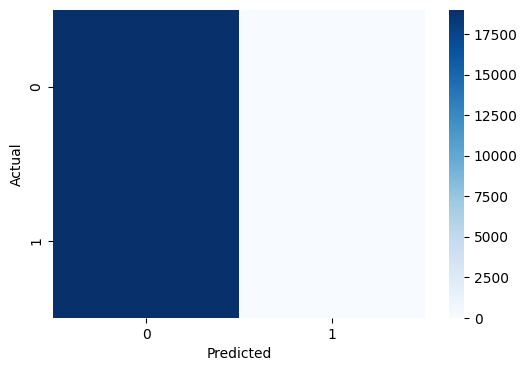

In [ ]:
# The above code was modified to address certain issues with type and
# label handling which were not an issue with the older vesions of the
# libraries the Chapter 4 notebook was using

evaluate(dataset_A["test"]["label"], y_pred, dataset_A_label_names)

In [ ]:
# simpler confusion matrix
confusion_matrix(dataset_A["test"]["label"], y_pred)

"""
Poor model performance could be attributed to mismatch between model
choice and dataset selection, for which the model was not aptly trained on.
But the choice was made in order to explore how the model generalizes,
in the same spirit the textbook uses the Twitter RoBERTa Sentiment Analysis model.

"""


In [ ]:
print("\n--- Example Predictions: Approach 1 Task-Specific Transformer (Yelp) ---")

# We will look at the first 5 examples from the test set
# (Assuming dataset_A_label_names is defined as ["Negative", "Positive"])

for i in range(5):
    # Retrieve the raw text and the true label index
    text = dataset_A["test"]["text"][i]
    true_index = dataset_A["test"]["label"][i]

    # Retrieve the prediction we already made (stored in y_pred)
    pred_index = y_pred[i]

    # Convert indices to string labels for readability
    true_label_str = dataset_A_label_names[true_index]
    pred_label_str = dataset_A_label_names[pred_index]

    # Print the details
    print(f"Review: {text[:120]}...")  # Truncate text to 120 chars for cleaner output
    print(f"True Label: {true_label_str} | Predicted Label: {pred_label_str}")

    # Add Interpretation based on match/mismatch
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The model successfully identified the sentiment keywords.")
    else:
        print("INTERPRETATION: Incorrect. The model may have struggled with sarcasm, neutrality, or mixed signals.")

    print("-" * 40)


--- Example Predictions: Approach 1 Task-Specific Transformer (Yelp) ---
Review: Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here...
True Label: Positive | Predicted Label: Negative
INTERPRETATION: Incorrect. The model may have struggled with sarcasm, neutrality, or mixed signals.
----------------------------------------
Review: Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them t...
True Label: Negative | Predicted Label: Negative
INTERPRETATION: Correct. The model successfully identified the sentiment keywords.
----------------------------------------
Review: Friendly staff, same starbucks fair you get anywhere else.  Sometimes the lines can get long....
True Label: Positive | Predicted Label: Negative
INTERPRETATION: Incorrect. The model may have struggled with sarcasm, neutrality, or mixed signals.
----------------------------------------
Revi

### **Classification Tasks that Leverage Embeddings**

#### Supervised Classification

#### Approach 2: Embedding-Based Classification (Logistic Regression)

In [ ]:
'''
Due to the sheer size of the Yelp dataset, it does not seem practical to encode the embeddings
for all rows of the dataset. It took 20 minutes of running just to get through 7% of the batch.

Thus for the sake of this assignment, I will be subsampling the Yelp dataset to make it smaller
and managable in size.
'''
from datasets import DatasetDict

def subsample(dataset, n_train=20000, n_test=5000, seed=42):
    train = dataset["train"].shuffle(seed=seed).select(range(n_train))
    test = dataset["test"].shuffle(seed=seed).select(range(n_test))
    return DatasetDict({"train": train, "test": test})

dataset_A_small = subsample(dataset_A)



In [ ]:
# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to embeddings

train_texts = list(dataset_A_small["train"]["text"])
test_texts  = list(dataset_A_small["test"]["text"])

train_embeddings = model.encode(train_texts, show_progress_bar=True)
test_embeddings  = model.encode(test_texts, show_progress_bar=True)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
train_embeddings.shape

(20000, 768)

In [ ]:
# Train a Logistic Regression on our train embeddings
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, dataset_A_small["train"]["label"])

LogisticRegression(random_state=42)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2533
           1       0.93      0.94      0.93      2467

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



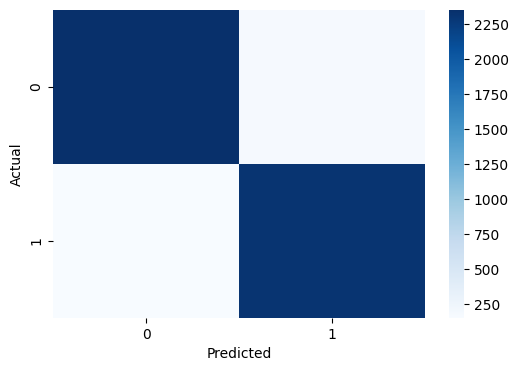

In [ ]:
# Predict previously unseen instances
y_pred = clf.predict(test_embeddings)
evaluate(dataset_A_small["test"]["label"], y_pred)

In [ ]:
# simpler confusion matrix
confusion_matrix(dataset_A_small["test"]["label"], y_pred)


array([[2352,  181],
       [ 154, 2313]])

In [ ]:
print("\n--- Example Predictions: Approach 2 Logistic Regression (Yelp) ---")

# We inspect the first 5 examples from your 'dataset_A_small' test set
for i in range(5):
    # Retrieve the text and true label from your subsampled dataset
    text = dataset_A_small["test"]["text"][i]
    true_index = dataset_A_small["test"]["label"][i]

    # Retrieve the prediction from your 'y_pred' array
    pred_index = y_pred[i]

    # Convert to strings (assuming dataset_A_label_names = ["Negative", "Positive"])
    true_label_str = dataset_A_label_names[true_index]
    pred_label_str = dataset_A_label_names[pred_index]

    print(f"Review: {text[:120]}...")
    print(f"True: {true_label_str} | Predicted: {pred_label_str}")

    # Interpretation logic
    if true_index == pred_index:
        print("INTERPRETATION: The embedding vector correctly captured the sentiment features (semantics).")
    else:
        # Logistic Regression on embeddings sometimes fails on negation (e.g., "not bad")
        print("INTERPRETATION: MISCLASSIFICATION. The vector average might have been skewed by conflicting words.")

    print("-" * 40)


--- Example Predictions: Approach 2 Logistic Regression (Yelp) ---
Review: Nightclub rating only...\n\nWe got lucky because we happened to arrive during Kris Humphries' (new husband of Kim Kardas...
True: Positive | Predicted: Negative
INTERPRETATION: MISCLASSIFICATION. The vector average might have been skewed by conflicting words.
----------------------------------------
Review: Absolutely atrocious service, while there were only three tables of customers at 7pm on a Saturday night.  To top it off...
True: Negative | Predicted: Negative
INTERPRETATION: The embedding vector correctly captured the sentiment features (semantics).
----------------------------------------
Review: Worst customer service ever.  While some things that went wrong were out of their control, this so called \""business\""...
True: Negative | Predicted: Negative
INTERPRETATION: The embedding vector correctly captured the sentiment features (semantics).
----------------------------------------
Review: L.A. people

#### Approach 3: Centroid-Based Similarity

              precision    recall  f1-score   support

    Negative       0.89      0.82      0.85      2533
    Positive       0.83      0.90      0.86      2467

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



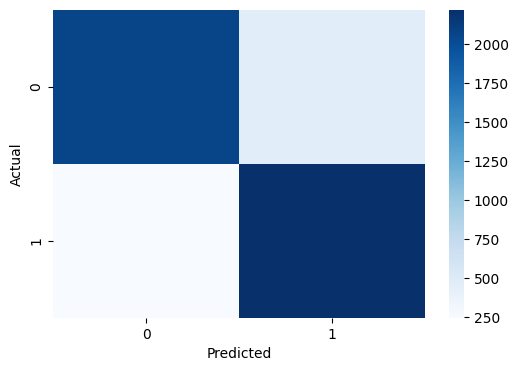

array([[2070,  463],
       [ 244, 2223]])

In [ ]:
# I don't believe Centroid-Based Similarity was covered in Chapter 4 explicitly

# Compute class centroids from training embeddings
train_labels = np.array(dataset_A_small["train"]["label"])

negative_centroid = train_embeddings[train_labels == 0].mean(axis=0)
positive_centroid = train_embeddings[train_labels == 1].mean(axis=0)

centroids = np.vstack([negative_centroid, positive_centroid])

# Compute cosine similarity between test embeddings and centroids
similarities = cosine_similarity(test_embeddings, centroids)

# Pick closest centroid
y_pred = np.argmax(similarities, axis=1)

evaluate(dataset_A_small["test"]["label"], y_pred, dataset_A_label_names)
confusion_matrix(dataset_A_small["test"]["label"], y_pred)

In [ ]:
print("\n--- Example Predictions: Approach 3 Centroid Similarity (Yelp) ---")

# We inspect the first 5 examples from your 'dataset_A_small' test set
for i in range(5):
    # Retrieve text and labels
    text = dataset_A_small["test"]["text"][i]
    true_index = dataset_A_small["test"]["label"][i]
    pred_index = y_pred[i]  # Prediction from the centroid logic

    # Convert indices to strings
    true_label_str = dataset_A_label_names[true_index]
    pred_label_str = dataset_A_label_names[pred_index]

    print(f"Review: {text[:120]}...")
    print(f"True: {true_label_str} | Predicted: {pred_label_str}")

    # Interpretation
    if true_index == pred_index:
        print("INTERPRETATION: The review's embedding vector was closer to the correct class centroid.")
    else:
        # Centroids often fail on outliers or reviews with mixed sentiment
        print("INTERPRETATION: MISCLASSIFICATION. This review might be an outlier, sitting far from the 'average' cluster.")

    print("-" * 40)


--- Example Predictions: Approach 3 Centroid Similarity (Yelp) ---
Review: Nightclub rating only...\n\nWe got lucky because we happened to arrive during Kris Humphries' (new husband of Kim Kardas...
True: Positive | Predicted: Negative
INTERPRETATION: MISCLASSIFICATION. This review might be an outlier, sitting far from the 'average' cluster.
----------------------------------------
Review: Absolutely atrocious service, while there were only three tables of customers at 7pm on a Saturday night.  To top it off...
True: Negative | Predicted: Negative
INTERPRETATION: The review's embedding vector was closer to the correct class centroid.
----------------------------------------
Review: Worst customer service ever.  While some things that went wrong were out of their control, this so called \""business\""...
True: Negative | Predicted: Negative
INTERPRETATION: The review's embedding vector was closer to the correct class centroid.
----------------------------------------
Review: L.A. peopl

#### Approach 4: Zero-Shot Classification

              precision    recall  f1-score   support

    Negative       0.82      0.91      0.86      2533
    Positive       0.89      0.80      0.84      2467

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000



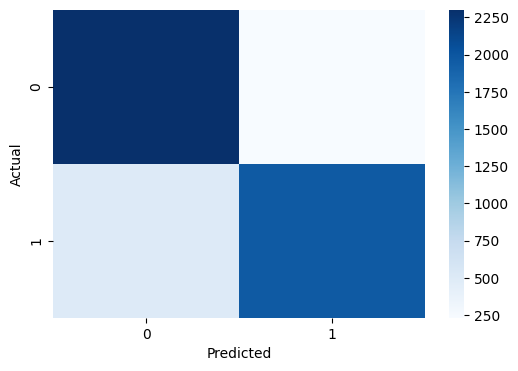

In [ ]:
# Textbook approach

# Create embeddings for our labels
label_embeddings = model.encode(["A negative review",  "A positive review"])

from sklearn.metrics.pairwise import cosine_similarity

# Find the best matching label for each document
sim_matrix = cosine_similarity(test_embeddings, label_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

evaluate(dataset_A_small["test"]["label"], y_pred, dataset_A_label_names)

In [ ]:
print("\n--- Example Predictions: Approach 4 Label-Embedding Zero-Shot (Yelp) ---")

# We inspect the first 5 examples from your 'dataset_A_small' test set
for i in range(5):
    # Retrieve text and true label
    text = dataset_A_small["test"]["text"][i]
    true_index = dataset_A_small["test"]["label"][i]
    pred_index = y_pred[i]  # Prediction from the label-embedding logic

    # Convert indices to strings
    true_label_str = dataset_A_label_names[true_index]
    pred_label_str = dataset_A_label_names[pred_index]

    print(f"Review: {text[:120]}...")
    print(f"True: {true_label_str} | Predicted: {pred_label_str}")

    # Interpretation
    if true_index == pred_index:
        print("INTERPRETATION: The review text was semantically closer to the correct label description.")
    else:
        # Zero-shot label matching often fails on sarcasm or indirect phrasing
        print("INTERPRETATION: MISCLASSIFICATION. The semantic meaning of the text did not align with the label embedding.")

    print("-" * 40)


--- Example Predictions: Approach 4 Label-Embedding Zero-Shot (Yelp) ---
Review: Nightclub rating only...\n\nWe got lucky because we happened to arrive during Kris Humphries' (new husband of Kim Kardas...
True: Positive | Predicted: Negative
INTERPRETATION: MISCLASSIFICATION. The semantic meaning of the text did not align with the label embedding.
----------------------------------------
Review: Absolutely atrocious service, while there were only three tables of customers at 7pm on a Saturday night.  To top it off...
True: Negative | Predicted: Negative
INTERPRETATION: The review text was semantically closer to the correct label description.
----------------------------------------
Review: Worst customer service ever.  While some things that went wrong were out of their control, this so called \""business\""...
True: Negative | Predicted: Negative
INTERPRETATION: The review text was semantically closer to the correct label description.
----------------------------------------
Review: 

#### Approach 5: Generative Model Classification

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]

              precision    recall  f1-score   support

    Negative       0.99      0.96      0.97       516
    Positive       0.95      0.99      0.97       484

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



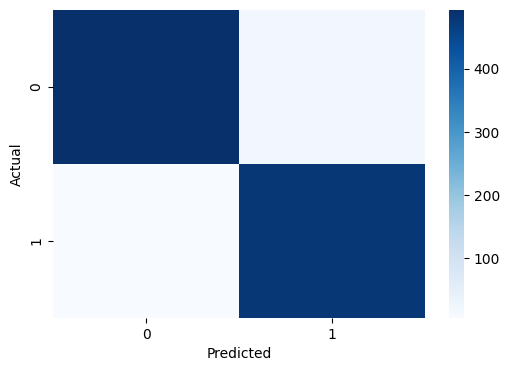

array([[493,  23],
       [  6, 478]])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

def classify_sentiment(prompt_text):
    prompt = (
        "Classify the sentiment of the following review as Positive or Negative.\n\n"
        f"Review: {prompt_text}\n\nSentiment:"
    )

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to("cuda")
    outputs = flan_model.generate(**inputs, max_new_tokens=5)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return 1 if "positive" in response.lower() else 0


# Run classification (small subset for runtime reasons)
subset_size = 1000

y_pred = []
y_true = dataset_A_small["test"]["label"][:subset_size]

for text in tqdm(dataset_A_small["test"]["text"][:subset_size]):
    y_pred.append(classify_sentiment(text))

evaluate(y_true, y_pred, dataset_A_label_names)
confusion_matrix(y_true, y_pred)

In [ ]:
print("\n--- Example Predictions: Approach 5 Generative Model (Yelp) ---")

# We inspect the first 5 examples from the subset you just processed
for i in range(5):
    # Retrieve text and true label from the subset
    text = dataset_A_small["test"]["text"][i]
    true_index = y_true[i]  # Using the y_true list you created
    pred_index = y_pred[i]  # Using the y_pred list you created

    # Convert indices to strings
    true_label_str = dataset_A_label_names[true_index]
    pred_label_str = dataset_A_label_names[pred_index]

    print(f"Review: {text[:120]}...")
    print(f"True: {true_label_str} | Predicted: {pred_label_str}")

    # Interpretation
    if true_index == pred_index:
        print("INTERPRETATION: The LLM correctly understood the sentiment and generated the matching token.")
    else:
        # Generative models sometimes hallucinate or get confused by double negatives
        print("INTERPRETATION: MISCLASSIFICATION. The LLM might have focused on a specific negative word despite the overall positive context (or vice versa).")

    print("-" * 40)


--- Example Predictions: Approach 5 Generative Model (Yelp) ---
Review: Nightclub rating only...\n\nWe got lucky because we happened to arrive during Kris Humphries' (new husband of Kim Kardas...
True: Positive | Predicted: Negative
INTERPRETATION: MISCLASSIFICATION. The LLM might have focused on a specific negative word despite the overall positive context (or vice versa).
----------------------------------------
Review: Absolutely atrocious service, while there were only three tables of customers at 7pm on a Saturday night.  To top it off...
True: Negative | Predicted: Negative
INTERPRETATION: The LLM correctly understood the sentiment and generated the matching token.
----------------------------------------
Review: Worst customer service ever.  While some things that went wrong were out of their control, this so called \""business\""...
True: Negative | Predicted: Negative
INTERPRETATION: The LLM correctly understood the sentiment and generated the matching token.
----------------

# Classification Approaches for Dataset B


In [ ]:
# Load banking77
dataset_B = load_dataset("banking77")

# Inspect splits and sample records
dataset_B

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [ ]:
# Prepare Dataset B text and labels

dataset_B_train_texts = dataset_B["train"]["text"]
dataset_B_train_labels = dataset_B["train"]["label"]

dataset_B_test_texts = dataset_B["test"]["text"]
dataset_B_test_labels = dataset_B["test"]["label"]

dataset_B_label_names = dataset_B["train"].features["label"].names

In [ ]:
print(dataset_B_train_texts)
print(dataset_B_train_labels)
print(dataset_B_label_names)


print(type(dataset_B_train_texts))
print(type(dataset_B_train_labels))
print(type(dataset_B_label_names))


Column(['I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?", 'I have been waiting over a week. Is the card still coming?', 'Can I track my card while it is in the process of delivery?', 'How do I know if I will get my card, or if it is lost?', ...])
Column([11, 11, 11, 11, 11, ...])
['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declin

In [ ]:
# Prepare text and label fields
dataset_B["train"][0, -1]

{'text': ['I am still waiting on my card?',
  'Which countries are represented?'],
 'label': [11, 24]}

#### Approach 1: Task-Specific Classification Model

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: mrm8488/distilroberta-finetuned-banking77
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Running inference with mrm8488/distilroberta-finetuned-banking77...


100%|██████████| 3080/3080 [00:03<00:00, 878.69it/s]



--- Approach 1: Task-Specific Model Performance (Banking77) ---
                                                  precision    recall  f1-score   support

                                activate_my_card       0.97      0.97      0.97        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.97      0.97      0.97        40
                                automatic_top_up       1.00      0.88      0.93        40
         balance_not_updated_after_bank_transfer       0.73      0.82      0.78        40
balance_not_updated_after_cheque_or_cash_deposit       0.97      0.95      0.96        40
                         beneficiary_not_allowed       0.85      0.85      0.85        40
                                 cancel_transfer       1.00      0.95      0.97        40
                            card_a

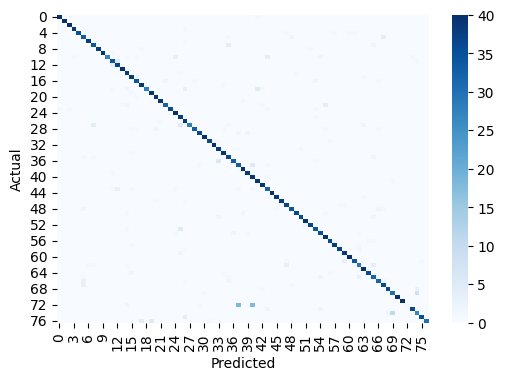

In [ ]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

# We use a model specifically fine-tuned for Banking77
# 'mrm8488/distilroberta-finetuned-banking77' is a popular choice for this dataset
model_path_B = "mrm8488/distilroberta-finetuned-banking77"

pipe_B = pipeline(
    "text-classification",
    model=model_path_B,
    tokenizer=model_path_B,
    device=0  # Use GPU
)

print(f"Running inference with {model_path_B}...")

# Run inference on the test set
# Note: This model returns label names (e.g., "card_arrival") rather than IDs
predictions_B_task = []
for output in tqdm(pipe_B(KeyDataset(dataset_B["test"], "text"), batch_size=16), total=len(dataset_B["test"])):
    pred_label_str = output["label"]

    # Map string label back to integer ID for evaluation consistency
    if pred_label_str in dataset_B_label_names:
        predictions_B_task.append(dataset_B_label_names.index(pred_label_str))
    else:
        # Fallback if label format mismatches (rare)
        predictions_B_task.append(-1)

# Evaluate
print("\n--- Approach 1: Task-Specific Model Performance (Banking77) ---")
evaluate(dataset_B["test"]["label"], predictions_B_task, dataset_B_label_names)


In [ ]:
print("\n--- Example Predictions: Approach 1 Task-Specific Model (Banking77) ---")

# We look at the first 5 examples from the Banking77 test set
for i in range(5):
    # Retrieve the raw text and true label index
    text = dataset_B["test"]["text"][i]
    true_index = dataset_B["test"]["label"][i]

    # Retrieve the prediction index from your 'predictions_B_task' list
    pred_index = predictions_B_task[i]

    # Convert indices to string labels for readability
    # (Assuming dataset_B_label_names is the list of 77 intent names)
    true_label_str = dataset_B_label_names[true_index]

    # Handle the rare -1 fallback case just in case
    if pred_index != -1:
        pred_label_str = dataset_B_label_names[pred_index]
    else:
        pred_label_str = "UNKNOWN_LABEL"

    print(f"Query: {text}")
    print(f"True Intent: {true_label_str}")
    print(f"Predicted:   {pred_label_str}")

    # Interpretation logic
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The fine-tuned model recognized the specific domain terminology.")
    else:
        # Fine-tuned models usually fail on ambiguity between very similar classes (e.g., card_lost vs card_stolen)
        print("INTERPRETATION: MISCLASSIFICATION. The model likely struggled to distinguish between two highly similar banking intents.")

    print("-" * 50)


--- Example Predictions: Approach 1 Task-Specific Model (Banking77) ---
Query: How do I locate my card?
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The fine-tuned model recognized the specific domain terminology.
--------------------------------------------------
Query: I still have not received my new card, I ordered over a week ago.
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The fine-tuned model recognized the specific domain terminology.
--------------------------------------------------
Query: I ordered a card but it has not arrived. Help please!
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The fine-tuned model recognized the specific domain terminology.
--------------------------------------------------
Query: Is there a way to know when my card will arrive?
True Intent: card_arrival
Predicted:   card_delivery_estimate
INTERPRETATION: MISCLASSIFICATION. The model likely struggled to

##### For this step, we use a pre-trained model from Hugging Face that has already been fine-tuned on the Banking77 dataset (unlike the Sentiment model used for Yelp).

#### Approach 2: Embedding-Based Classification (Logistic Regression)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding Dataset B Train...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Encoding Dataset B Test...


Batches:   0%|          | 0/97 [00:00<?, ?it/s]


--- Approach 2: Logistic Regression with Embeddings (Banking77) ---
                                                  precision    recall  f1-score   support

                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       0.98      1.00      0.99        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       1.00      0.95      0.97        40
                                automatic_top_up       0.97      0.97      0.97        40
         balance_not_updated_after_bank_transfer       0.79      0.82      0.80        40
balance_not_updated_after_cheque_or_cash_deposit       0.97      0.95      0.96        40
                         beneficiary_not_allowed       0.89      0.80      0.84        40
                                 cancel_transfer       0.95      1.00      0.98        40
                            ca

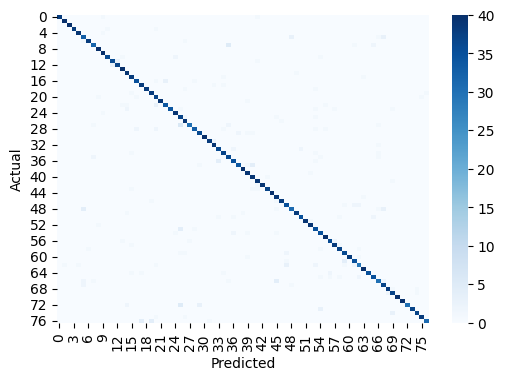

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

# Load embedding model (if not already loaded)
model_emb = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Banking77 is relatively small (10k train), so we can use the full dataset
# or a large subset if you are time-constrained.
train_texts_B = dataset_B["train"]["text"]
test_texts_B = dataset_B["test"]["text"]

print("Encoding Dataset B Train...")
train_embeddings_B = model_emb.encode(train_texts_B, show_progress_bar=True)
print("Encoding Dataset B Test...")
test_embeddings_B = model_emb.encode(test_texts_B, show_progress_bar=True)

# Train Logistic Regression
# We increase max_iter because 77 classes can take longer to converge
clf_B = LogisticRegression(random_state=42, max_iter=1000)
clf_B.fit(train_embeddings_B, dataset_B["train"]["label"])

# Predict
y_pred_B_lr = clf_B.predict(test_embeddings_B)

print("\n--- Approach 2: Logistic Regression with Embeddings (Banking77) ---")
evaluate(dataset_B["test"]["label"], y_pred_B_lr, dataset_B_label_names)

In [ ]:
print("\n--- Example Predictions: Approach 2 Logistic Regression (Banking77) ---")

# We look at the first 5 examples from the Banking77 test set
for i in range(5):
    # Retrieve the text and true label index
    text = dataset_B["test"]["text"][i]
    true_index = dataset_B["test"]["label"][i]

    # Retrieve the prediction from the Logistic Regression output
    pred_index = y_pred_B_lr[i]

    # Convert indices to string labels
    true_label_str = dataset_B_label_names[true_index]
    pred_label_str = dataset_B_label_names[pred_index]

    print(f"Query: {text}")
    print(f"True Intent: {true_label_str}")
    print(f"Predicted:   {pred_label_str}")

    # Interpretation logic
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The embedding placed this query in the correct decision boundary.")
    else:
        # Logistic Regression on embeddings is generally robust but can fail on subtle boundaries
        print("INTERPRETATION: MISCLASSIFICATION. The query vector was likely near the boundary of a semantically similar class.")

    print("-" * 50)


--- Example Predictions: Approach 2 Logistic Regression (Banking77) ---
Query: How do I locate my card?
True Intent: card_arrival
Predicted:   lost_or_stolen_card
INTERPRETATION: MISCLASSIFICATION. The query vector was likely near the boundary of a semantically similar class.
--------------------------------------------------
Query: I still have not received my new card, I ordered over a week ago.
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The embedding placed this query in the correct decision boundary.
--------------------------------------------------
Query: I ordered a card but it has not arrived. Help please!
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The embedding placed this query in the correct decision boundary.
--------------------------------------------------
Query: Is there a way to know when my card will arrive?
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The embedding pl

##### We reuse the SentenceTransformer to generate embeddings. Since Banking77 is smaller than Yelp (approx 10k train vs 500k), we can likely use the full training set without aggressive subsampling, but you can subsample if it runs too slowly.

#### Approach 3: Centroid-Based Similarity


--- Approach 3: Centroid-Based Similarity (Banking77) ---
                                                  precision    recall  f1-score   support

                                activate_my_card       0.97      0.93      0.95        40
                                       age_limit       0.98      1.00      0.99        40
                         apple_pay_or_google_pay       0.97      0.93      0.95        40
                                     atm_support       1.00      0.93      0.96        40
                                automatic_top_up       0.94      0.75      0.83        40
         balance_not_updated_after_bank_transfer       0.75      0.82      0.79        40
balance_not_updated_after_cheque_or_cash_deposit       0.95      0.97      0.96        40
                         beneficiary_not_allowed       0.91      0.53      0.67        40
                                 cancel_transfer       0.95      1.00      0.98        40
                            card_about_t

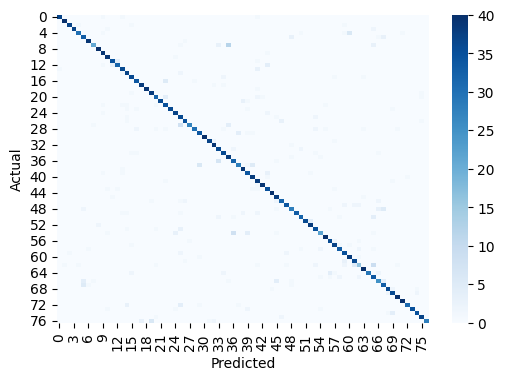

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Create a DataFrame to group embeddings by label
df_B = pd.DataFrame(train_embeddings_B)
df_B['label'] = dataset_B["train"]["label"]

# 2. Calculate the mean embedding (centroid) for each of the 77 classes
centroids_B = df_B.groupby('label').mean().values

# 3. Compute cosine similarity between Test Embeddings and the 77 Centroids
sim_matrix_B = cosine_similarity(test_embeddings_B, centroids_B)

# 4. Pick the class with the highest similarity score
y_pred_B_centroid = np.argmax(sim_matrix_B, axis=1)

print("\n--- Approach 3: Centroid-Based Similarity (Banking77) ---")
evaluate(dataset_B["test"]["label"], y_pred_B_centroid, dataset_B_label_names)

In [ ]:
print("\n--- Example Predictions: Approach 3 Centroid Similarity (Banking77) ---")

# We inspect the first 5 examples from the Banking77 test set
for i in range(5):
    # Retrieve the text and true label index
    text = dataset_B["test"]["text"][i]
    true_index = dataset_B["test"]["label"][i]

    # Retrieve the prediction index from the centroid logic
    pred_index = y_pred_B_centroid[i]

    # Convert indices to string labels
    true_label_str = dataset_B_label_names[true_index]
    pred_label_str = dataset_B_label_names[pred_index]

    print(f"Query: {text}")
    print(f"True Intent: {true_label_str}")
    print(f"Predicted:   {pred_label_str}")

    # Interpretation logic
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The query vector is close to the 'center of mass' for this intent cluster.")
    else:
        # Centroids fail when a specific query is an outlier, far from the class average
        print("INTERPRETATION: MISCLASSIFICATION. This specific query might use unique phrasing that places it far from the average examples of its true class.")

    print("-" * 50)


--- Example Predictions: Approach 3 Centroid Similarity (Banking77) ---
Query: How do I locate my card?
True Intent: card_arrival
Predicted:   lost_or_stolen_card
INTERPRETATION: MISCLASSIFICATION. This specific query might use unique phrasing that places it far from the average examples of its true class.
--------------------------------------------------
Query: I still have not received my new card, I ordered over a week ago.
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The query vector is close to the 'center of mass' for this intent cluster.
--------------------------------------------------
Query: I ordered a card but it has not arrived. Help please!
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The query vector is close to the 'center of mass' for this intent cluster.
--------------------------------------------------
Query: Is there a way to know when my card will arrive?
True Intent: card_arrival
Predicted:   card_

##### This approach calculates the "average meaning" (centroid) of each of the 77 intents and classifies new queries by finding the closest centroid.

#### Approach 4: Zero-Shot Classification

Encoding Label Names...

--- Approach 4: Zero-Shot Classification (Banking77) ---
                                                  precision    recall  f1-score   support

                                activate_my_card       0.50      0.93      0.65        40
                                       age_limit       0.97      0.70      0.81        40
                         apple_pay_or_google_pay       0.83      0.38      0.52        40
                                     atm_support       0.86      0.80      0.83        40
                                automatic_top_up       0.88      0.55      0.68        40
         balance_not_updated_after_bank_transfer       0.70      0.57      0.63        40
balance_not_updated_after_cheque_or_cash_deposit       0.94      0.78      0.85        40
                         beneficiary_not_allowed       0.81      0.33      0.46        40
                                 cancel_transfer       0.93      0.62      0.75        40
                 

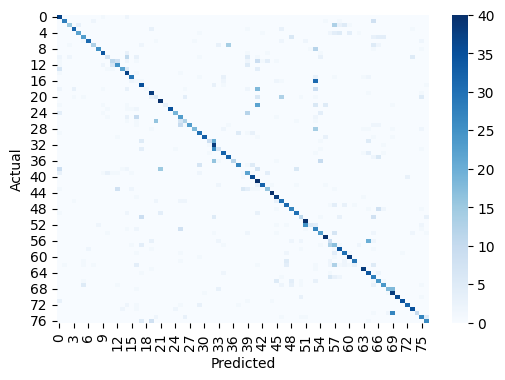

In [ ]:
# 1. Encode the 77 label names directly
print("Encoding Label Names...")
label_embeddings_B = model_emb.encode(dataset_B_label_names)

# 2. Compute similarity between document embeddings and label embeddings
sim_matrix_B_zs = cosine_similarity(test_embeddings_B, label_embeddings_B)

# 3. Predict the label with the closest name embedding
y_pred_B_zs = np.argmax(sim_matrix_B_zs, axis=1)

print("\n--- Approach 4: Zero-Shot Classification (Banking77) ---")
evaluate(dataset_B["test"]["label"], y_pred_B_zs, dataset_B_label_names)

In [ ]:
print("\n--- Example Predictions: Approach 4 Zero-Shot Classification (Banking77) ---")

# We inspect the first 5 examples from the Banking77 test set
for i in range(5):
    # Retrieve the raw text and true label index
    text = dataset_B["test"]["text"][i]
    true_index = dataset_B["test"]["label"][i]

    # Retrieve the prediction index from the Zero-Shot logic
    pred_index = y_pred_B_zs[i]

    # Convert indices to string labels
    true_label_str = dataset_B_label_names[true_index]
    pred_label_str = dataset_B_label_names[pred_index]

    print(f"Query: {text}")
    print(f"True Intent: {true_label_str}")
    print(f"Predicted:   {pred_label_str}")

    # Interpretation logic
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The label name itself describes the query well enough for a match.")
    else:
        # Zero-shot often fails when the label name is abstract (e.g., 'transfer_timing' vs 'pending_transfer')
        print("INTERPRETATION: MISCLASSIFICATION. The semantic meaning of the label name didn't align closely enough with the query text.")

    print("-" * 50)


--- Example Predictions: Approach 4 Zero-Shot Classification (Banking77) ---
Query: How do I locate my card?
True Intent: card_arrival
Predicted:   lost_or_stolen_card
INTERPRETATION: MISCLASSIFICATION. The semantic meaning of the label name didn't align closely enough with the query text.
--------------------------------------------------
Query: I still have not received my new card, I ordered over a week ago.
True Intent: card_arrival
Predicted:   activate_my_card
INTERPRETATION: MISCLASSIFICATION. The semantic meaning of the label name didn't align closely enough with the query text.
--------------------------------------------------
Query: I ordered a card but it has not arrived. Help please!
True Intent: card_arrival
Predicted:   card_arrival
INTERPRETATION: Correct. The label name itself describes the query well enough for a match.
--------------------------------------------------
Query: Is there a way to know when my card will arrive?
True Intent: card_arrival
Predicted:   car

##### Here we check how well the embeddings of the label names themselves match the user queries, without training a classifier.

#### Approach 5: Generative Model Classification

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Running Generative Classification on first 200 test items...


100%|██████████| 200/200 [00:28<00:00,  6.99it/s]


Mapping generated text to label IDs...

--- Approach 5: Generative Model Performance (Subset) ---
                                  precision    recall  f1-score   support

                activate_my_card       0.00      0.00      0.00         0
                       age_limit       0.00      0.00      0.00         0
                     atm_support       0.00      0.00      0.00         0
            card_about_to_expire       0.00      0.00      0.00         0
                 card_acceptance       0.00      0.00      0.00         0
                    card_arrival       0.75      0.23      0.35        40
          card_delivery_estimate       0.00      0.00      0.00         0
                    card_linking       1.00      0.12      0.22        40
                card_not_working       0.00      0.00      0.00         0
        card_payment_fee_charged       0.00      0.00      0.00         0
card_payment_wrong_exchange_rate       0.00      0.00      0.00        40
             

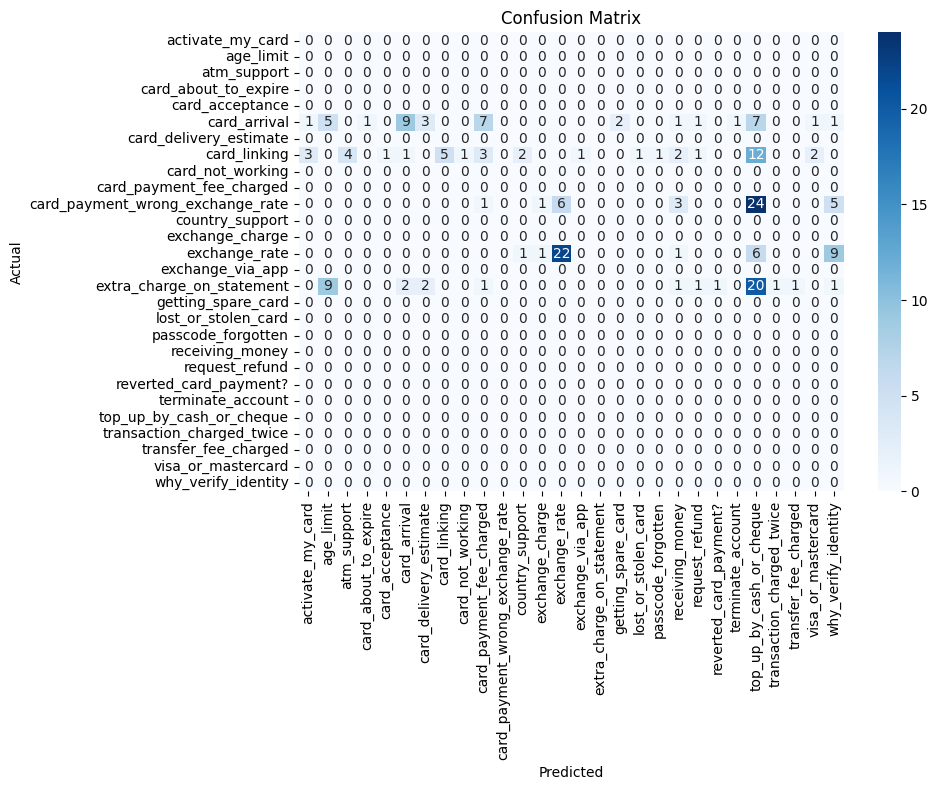

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# --- Step 1: Setup the Generative Model ---
model_name_gen = "google/flan-t5-base"
tokenizer_gen = AutoTokenizer.from_pretrained(model_name_gen)
model_gen = AutoModelForSeq2SeqLM.from_pretrained(model_name_gen).to("cuda")

def classify_intent_gen(prompt_text):
    prompt = (
        f"Identify the banking intent for the following query.\n\n"
        f"Query: {prompt_text}\n\n"
        "Intent:"
    )
    inputs = tokenizer_gen(prompt, return_tensors="pt", truncation=True).to("cuda")
    outputs = model_gen.generate(**inputs, max_new_tokens=10)
    return tokenizer_gen.decode(outputs[0], skip_special_tokens=True)

# --- Step 2: Generate Outputs for a Subset ---
# Generating for all 3k test items takes too long; using 200 for demonstration.
eval_size = 200
print(f"Running Generative Classification on first {eval_size} test items...")

gen_texts_B = []
# We store the true labels for this subset to compare against later
true_labels_subset = dataset_B["test"]["label"][:eval_size]

for text in tqdm(dataset_B["test"]["text"][:eval_size]):
    gen_texts_B.append(classify_intent_gen(text))

# --- Step 3: Map Free Text to Label IDs using Embeddings ---
# We need to map the model's text output (e.g., "card lost") to the specific Label ID (e.g., 42)
# We use the embedding model you loaded in Approach 2 ('model_emb')

print("Mapping generated text to label IDs...")
# Encode the text generated by the LLM
gen_embeddings_B = model_emb.encode(gen_texts_B)

# Encode the official label names (if not already done in Approach 4)
if 'label_embeddings_B' not in locals():
    label_embeddings_B = model_emb.encode(dataset_B_label_names)

# Find which official label is closest to the generated text
sim_matrix_gen = cosine_similarity(gen_embeddings_B, label_embeddings_B)
y_pred_B_gen = np.argmax(sim_matrix_gen, axis=1)

# --- Step 4: Evaluate ---
print("\n--- Approach 5: Generative Model Performance (Subset) ---")
evaluate(true_labels_subset, y_pred_B_gen, dataset_B_label_names)

In [ ]:
print("\n--- Example Predictions: Approach 5 Generative Model (Banking77) ---")

# We inspect the first 5 examples from the subset you just processed
for i in range(5):
    # Retrieve inputs and labels from the subset variables
    text = dataset_B["test"]["text"][i]
    true_index = true_labels_subset[i]
    pred_index = y_pred_B_gen[i]

    # Retrieve the RAW text the model generated (before mapping)
    raw_output = gen_texts_B[i]

    # Convert indices to string labels
    true_label_str = dataset_B_label_names[true_index]
    pred_label_str = dataset_B_label_names[pred_index]

    print(f"Query:       {text}")
    print(f"True Intent: {true_label_str}")
    print(f"Raw LLM Out: {raw_output}")     # Important to see what Flan-T5 actually wrote
    print(f"Mapped Pred: {pred_label_str}") # The closest label we found via embeddings

    # Interpretation
    if true_index == pred_index:
        print("INTERPRETATION: Correct. The LLM generated a phrase semantically identical to the official label.")
    elif raw_output.strip() == "":
        print("INTERPRETATION: FAILURE. The model generated an empty string, leading to a random or default mapping.")
    else:
        print("INTERPRETATION: MISCLASSIFICATION. The LLM's generated phrase was too vague or mapped to a neighboring concept (e.g., 'card issue' mapping to 'card_not_working' instead of 'card_arrival').")

    print("-" * 60)


--- Example Predictions: Approach 5 Generative Model (Banking77) ---
Query:       How do I locate my card?
True Intent: card_arrival
Raw LLM Out: To make a purchase
Mapped Pred: top_up_by_cash_or_cheque
INTERPRETATION: MISCLASSIFICATION. The LLM's generated phrase was too vague or mapped to a neighboring concept (e.g., 'card issue' mapping to 'card_not_working' instead of 'card_arrival').
------------------------------------------------------------
Query:       I still have not received my new card, I ordered over a week ago.
True Intent: card_arrival
Raw LLM Out: to get a refund
Mapped Pred: request_refund
INTERPRETATION: MISCLASSIFICATION. The LLM's generated phrase was too vague or mapped to a neighboring concept (e.g., 'card issue' mapping to 'card_not_working' instead of 'card_arrival').
------------------------------------------------------------
Query:       I ordered a card but it has not arrived. Help please!
True Intent: card_arrival
Raw LLM Out: None
Mapped Pred: age_limit
